#Kullanabileceğiniz data setleri


1.   MNIST: el yazısı sayıları tahmin etme 
2.   Iris Flower Dataset: çiçek özelliklerine göre türünü tahmin etme 
3.   Titanic Dataset: Yolcuların özelliklerine göre survival durumu
4.   Wine Quality Dataset: Şarap özelliklerine göre şarap sınıflandırması
5.   Boston Housing Dataset: Evlerin özelliklerine göre fiyatlandırma
6.   CIFAR-10 and CIFAR-100 Image Classification Datasets 
7.   Fashion-MNIST Dataset
8.   Breast Cancer Wisconsin (Diagnostic) Dataset
9.   California Housing Prices Dataset
10.  Credit Card Fraud Detection Dataset 

#https://pytorch.org/vision/stable/datasets.html




#CONVOLUTIONAL NEURAL NETWORK
#CONVNET YA DA CNN olarak bilinir.
Aslında biz nasıl bir sandalyeyi 4 ayağı var bir oturma yeri var diye çeşitli base özelliklerini bildiğimiz için tanımlıyorsak CNN de bunu yapar.
CNN görüntüyü çeşitli katmanlarla işler.
1. Convolutional Layers
2. Non-linear layers (ReLu)
3. Pooling Layer (downsampling)(dimension azaltmak için kullanılır.)
4. Flattening Layer 
5. Fully-Connected Layer
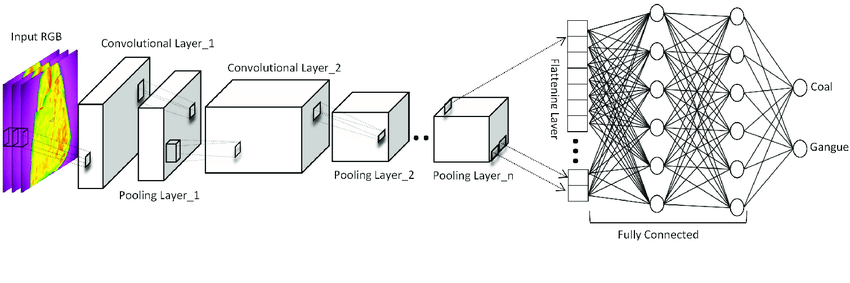

Kernels ve Convolutional Layer
Beynimizdeki gibi genel özellikleri çıkarmayı neural networkümüzde bu katmanda yapıyoruz. 
Kernel dediğimiz filtreler RGB resmimizin her katmanının üzerinde adım adım gezerek özellik çıkarma işlemi yapar. Ortaya çıkan resme Feature Map deriz. Bu özellik çıkarmayı farklı filtrelerle birden fazla kez yapabiliriz.
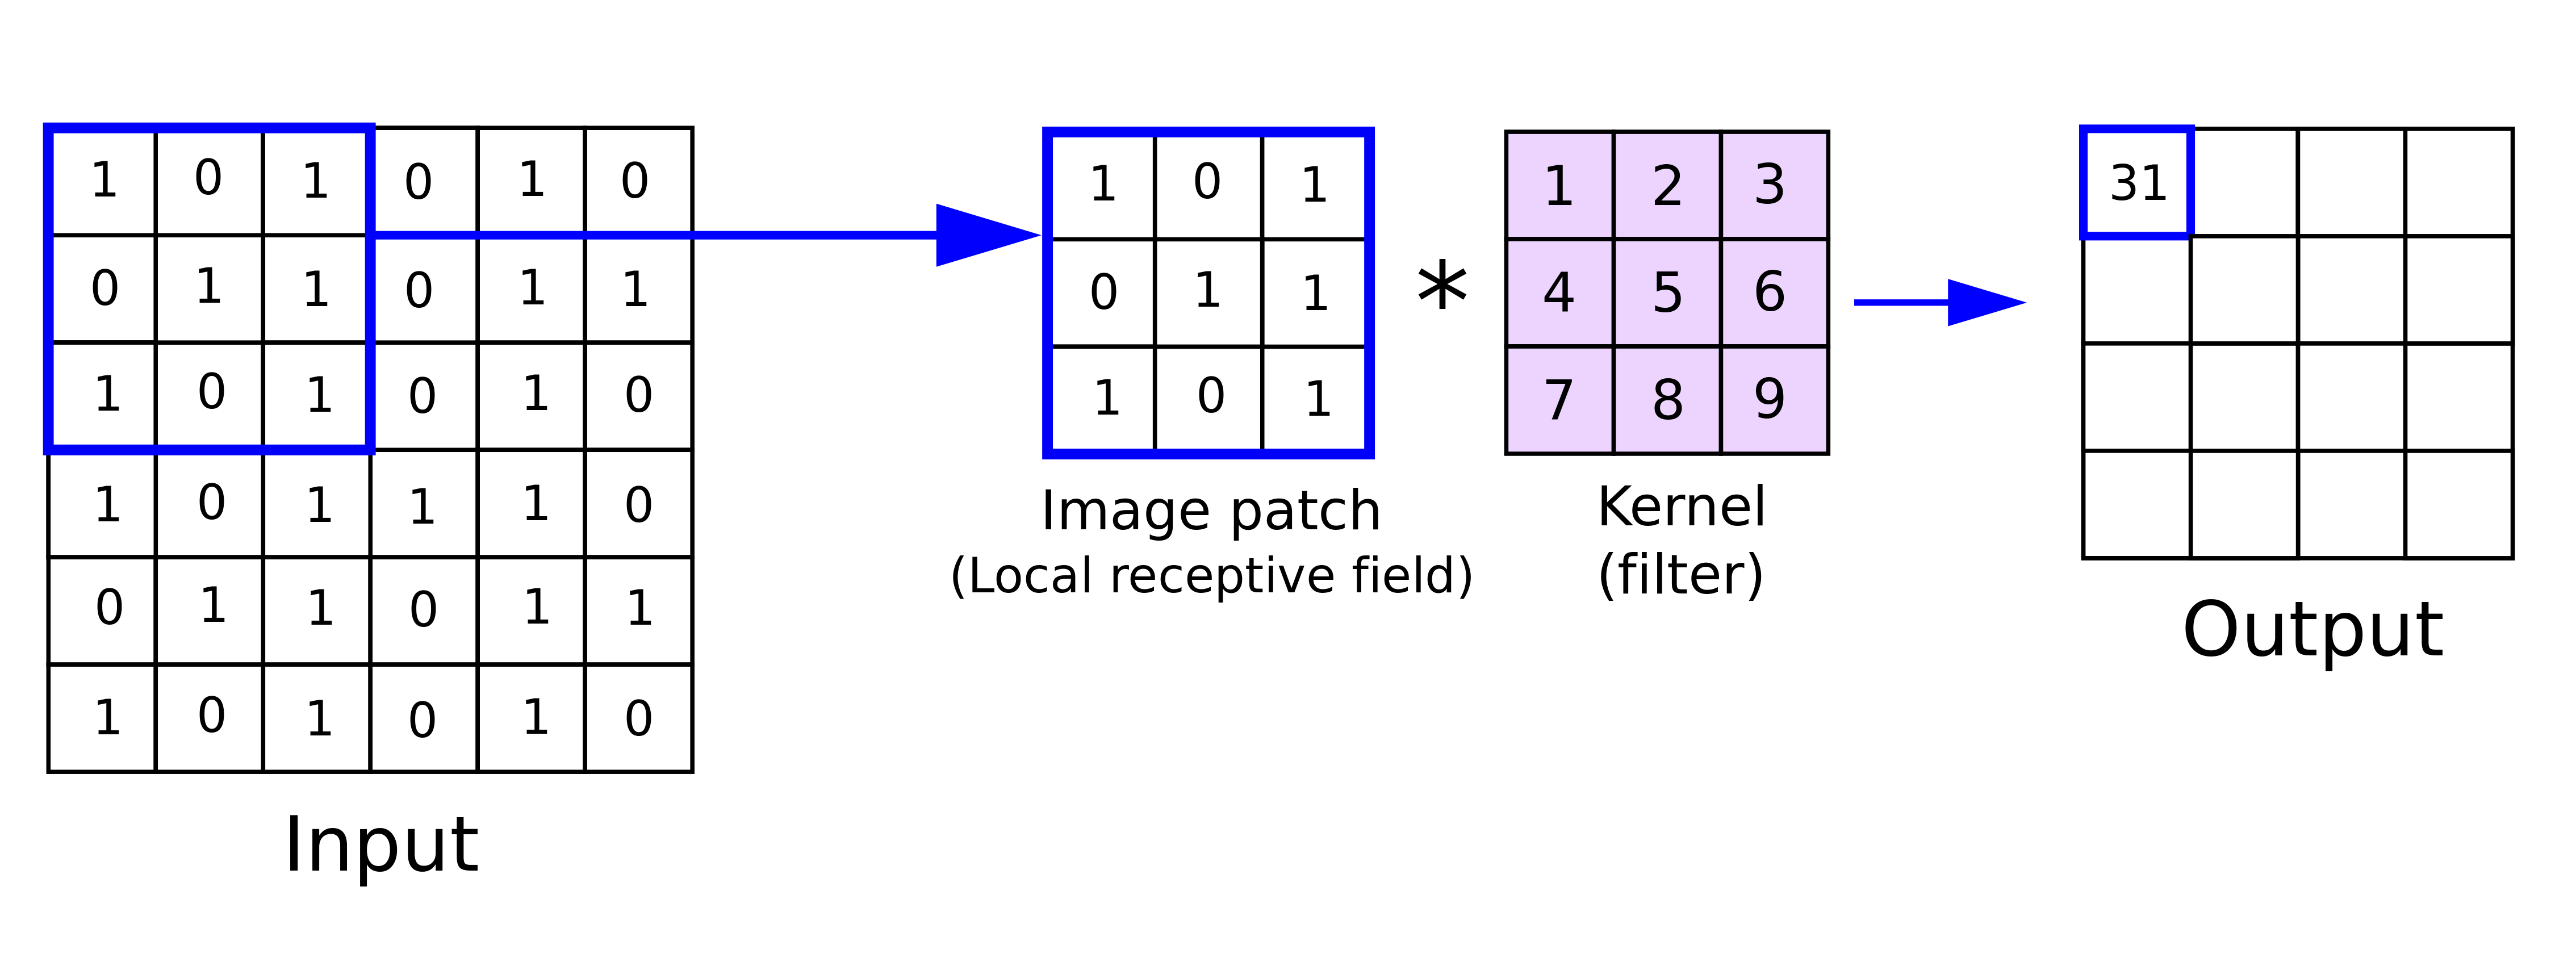


Fark ettiyseniz son çıkan output orijinale göre küçüldü. Küçülmemesi için resmin kenarlarına öncelikle 0'larla dolu olan bir çerçeve ekleriz. (Padding)
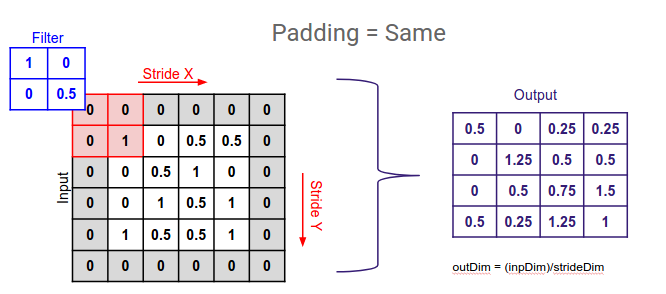

#POOLING
Pooling yapmamızın asıl amaçlarından biri resimden çıkartılan özelliklerin spesifik bir konumla eşleştirilmesini engellemektir. Yani aslında feature map'te çıkartılan özellikler genelde lokasyona bağlı olur. Ancak bu lokasyona bağlılığı gidermek için pooling kullanılabilir. Diğer bir sebebi de size'ı azaltmaktır. Böylece yapılacak çarpma işlemi sayısı ve karmaşıklık azalır. En temel olarak iki tane pooling işlemi kullanılır.
1. Max Pooling 
2. Average Pooling

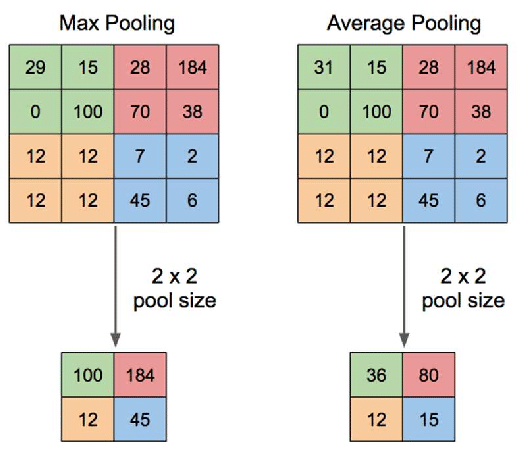

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

#Gpu tanımla 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Hiperparametreleri tanımla 
num_epochs = 10
batch_size = 64
learning_rate = 0.001

#CIFAR-10 datasetini train ve test olarak indir. İçinde transforms kullan 
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())

# Datasetler için dataloader oluştur. 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2) #num workers datayı daha hızlı yüklemek için kullanılır. 


100%|██████████| 170498071/170498071 [00:13<00:00, 12672540.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:

#CNN modelimizi oluşturalım
class my_CNN(nn.Module):
    def __init__(self):
        super(my_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1,)

        #in_channel = 3 (rgb), out_channel = 32 
        #out_channel sayısını sürekli olarak arttırmamızın sebebi daha karışık ve gizli özelliklerin öğrenilebilmesini sağlamak

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512) #128*4*4 neden böyle yaptığımızı az sonra anlatıcam 
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)
        #overfitting'i engellemek için inputtaki rastgele değerleri 0'a eşitliyor. Böylece noise'ları da öğrenmesi engellenmiş oluyor. 
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x) #relu size'ı değiştirmez.
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        #son fcl'dan önce ekliyoruz çünkü çok fazla parametre var. Bazılarını son katmandan önce sıfıra eşitleyip daha iyi öğrenmesini sağlıyoruz 
        x = self.fc2(x)
        return x

# modeli ekle, loss ve optimizer ekle 
model = my_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


1. x = self.conv1(x):
  *   input size: (batch_size, 3, 32, 32)
  *   output size: (batch_size, 32, 32, 32)

2. x = self.relu(x):
  *   input size: (batch_size, 32, 32, 32)
  *   output size: (batch_size, 32, 32, 32)

3. x = self.pool(x):
  *   input size: (batch_size, 32, 32, 32)
  *   output size: (batch_size, 32, 16, 16)

4. x = self.conv2(x):
  *   input size: (batch_size, 32, 16, 16)
  *   output size: (batch_size, 64, 16, 16)

5. x = self.relu(x):
  *   input size: (batch_size, 64, 16, 16)
  *   output size: (batch_size, 64, 16, 16)

6. x = self.pool(x):
  *   input size: (batch_size, 64, 16, 16)
  *   output size: (batch_size, 64, 8, 8)

7. x = self.conv3(x):
  *   input size: (batch_size, 64, 8, 8)
  *   output size: (batch_size, 128, 8, 8)

8. x = self.relu(x):
  *   input size: (batch_size, 128, 8, 8)
  *   output size: (batch_size, 128, 8, 8)

9. x = self.pool(x):
  *   input size: (batch_size, 128, 8, 8)
  *   output size: (batch_size, 128, 4, 4)

10. x = x.view(-1, 128 * 4 * 4):
  *   input size: (batch_size, 128, 4, 4)
  *   output size: (batch_size, 2048)

11. x = self.fc1(x):
  *   input size: (batch_size, 2048)
  *   output size: (batch_size, 512)

12. x = self.relu(x):
  *   input size: (batch_size, 512)
  *   output size: (batch_size, 512)

13. x = self.dropout(x):
  *   input size: (batch_size, 512)
  *   output size: (batch_size, 512) bazı yerler random olarak sıfıra atanır.

14. x = self.fc2(x):
  *   input size: (batch_size, 512)
  *   output size: (batch_size, 10)

In [3]:
#modeli eğit
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0


[1,   200] loss: 1.925
[1,   400] loss: 1.531
[1,   600] loss: 1.422
[2,   200] loss: 1.232
[2,   400] loss: 1.159
[2,   600] loss: 1.107
[3,   200] loss: 1.007
[3,   400] loss: 0.966
[3,   600] loss: 0.927
[4,   200] loss: 0.881
[4,   400] loss: 0.843
[4,   600] loss: 0.839
[5,   200] loss: 0.767
[5,   400] loss: 0.770
[5,   600] loss: 0.762
[6,   200] loss: 0.665
[6,   400] loss: 0.696
[6,   600] loss: 0.698
[7,   200] loss: 0.634
[7,   400] loss: 0.631
[7,   600] loss: 0.645
[8,   200] loss: 0.564
[8,   400] loss: 0.580
[8,   600] loss: 0.584
[9,   200] loss: 0.511
[9,   400] loss: 0.523
[9,   600] loss: 0.547
[10,   200] loss: 0.486
[10,   400] loss: 0.490
[10,   600] loss: 0.477


In [5]:
# model.eval() dediğimizde dropout katmanı çalışmaz.
model.eval()
correct_total = 0
total = 0
correct_class = [0] * 10
total_class = [0] * 10

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_total += (predicted == labels).sum().item()
        for i in range(labels.size(0)):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                correct_class[label] += 1
            total_class[label] += 1

accuracy_total = 100 * correct_total / total
print('Accuracy of the network on the test set: %d %%' % accuracy_total)

for i in range(10):
    accuracy_class = 100 * correct_class[i] / total_class[i]
    print('Accuracy of %5s : %2d %%' % (
        test_dataset.classes[i], accuracy_class))

Accuracy of the network on the test set: 76 %
Accuracy of airplane : 74 %
Accuracy of automobile : 84 %
Accuracy of  bird : 72 %
Accuracy of   cat : 59 %
Accuracy of  deer : 68 %
Accuracy of   dog : 70 %
Accuracy of  frog : 85 %
Accuracy of horse : 81 %
Accuracy of  ship : 84 %
Accuracy of truck : 81 %


In [9]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad and not isinstance(p, nn.Dropout))
print("Total number of parameters in the model before dropout: {}".format(total_params))

Total number of parameters in the model before dropout: 1147466


In [10]:
num_params_after_dropout = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters after dropout:", num_params_after_dropout)

Number of parameters after dropout: 1147466
